# <p align=center>  Проект: предсказание длительности поездки </p>

* Данные взяты из [kaggle-cоревнования](https://www.kaggle.com/competitions/nyc-taxi-trip-duration/overview "New York City Taxi Trip Duration") 2017 года с информацией о поездках на жёлтом такси в Нью-Йорке за 2016 год.

<center> <img src=https://storage.googleapis.com/kaggle-competitions/kaggle/3333/media/taxi_meter.png align="right" width="300"/> </center>
    

**Основные цели проекта:**
1. Сформировать набор данных на основе нескольких источников информации
2. Спроектировать новые признаки с помощью Feature Engineering и выявить наиболее значимые при построении модели
3. Исследовать предоставленные данные и выявить закономерности
4. Построить несколько моделей и выбрать из них наилучшую по заданной метрике
5. Спроектировать процесс предсказания времени длительности поездки для новых данных


## 1. Знакомство с данными, базовый анализ и расширение данных

Начнём наше исследование со знакомства с предоставленными данными. А также подгрузим дополнительные источники данных и расширим наш исходный датасет. 


In [121]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(context='notebook', style='darkgrid', palette='bright', font='serif', color_codes=True, 
              rc={'figure.figsize':(10,8), 'axes.titlesize':18,'axes.labelsize':16, 'font.family': 'Verdana', 'lines.linewidth': 2 })
import plotly.express as px
from scipy import stats
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import cluster
from sklearn import feature_selection
R_STATE = 42
from warnings import filterwarnings
filterwarnings("ignore", 'Creating legend with loc="best" can be slow with large amounts of data.')

In [122]:
taxi_data = pd.read_csv("data/train.csv")
print('Train data shape: {}'.format(taxi_data.shape))
taxi_data.head()

Train data shape: (1458644, 11)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


Итак, у нас с вами есть данные о почти 1.5 миллионах поездок и 11 характеристиках, которые описывают каждую из поездок. 

Мы условно разделили признаки нескольких групп. Каждой из групп мы в дальнейшем уделим отдельное внимание.

**Данные о клиенте и таксопарке:**
* id - уникальный идентификатор поездки
* vendor_id - уникальный идентификатор поставщика (таксопарка), связанного с записью поездки

**Временные характеристики:**
* pickup_datetime - дата и время, когда был включен счетчик поездки
* dropoff_datetime - дата и время, когда счетчик был отключен

**Географическая информация:**
* pickup_longitude -  долгота, на которой был включен счетчик
* pickup_latitude - широта, на которой был включен счетчик
* dropoff_longitude - долгота, на которой счетчик был отключен
* dropoff_latitude - широта, на которой счетчик был отключен

**Прочие признаки:**
* passenger_count - количество пассажиров в транспортном средстве (введенное водителем значение)
* store_and_fwd_flag - флаг, который указывает, сохранилась ли запись о поездке в памяти транспортного средства перед отправкой поставщику. Y - хранить и пересылать, N - не хранить и не пересылать поездку.

**Целевой признак:**
* trip_duration - продолжительность поездки в секундах


Для начала мы проведем базовый анализ того, насколько данные готовы к дальнейшей предобработке и анализу. 

In [123]:
taxi_data['pickup_datetime'] = pd.to_datetime(taxi_data['pickup_datetime'])
taxi_data['pickup_datetime'].max() - taxi_data['pickup_datetime'].min()

Timedelta('181 days 23:59:22')

Посмотрим на наличие значений `NaN` и `None` в данных. 

In [124]:
taxi_data.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [125]:
display(taxi_data.describe())
print(f"Уникальных таксопарков: {taxi_data['vendor_id'].unique().shape[0]}")


,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1458644,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,2016-04-01 10:10:24.940037120,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
min,1.000000e+00,2016-01-01 00:00:17,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,2016-02-17 16:46:04.249999872,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,2016-04-01 17:19:40,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2016-05-15 03:56:08.750000128,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,2016-06-30 23:59:39,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06
std,4.987772e-01,NaN,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03


Уникальных таксопарков: 2


> Явные выбросы со значением длительности поездки в 1 секунду и более 40 дней

Займемся расширением исходного набора данных как с помощью внешних источников, так и с помощью манипуляций над имеющимися в данных признаками. 


In [126]:
def add_datetime_features(df: pd.DataFrame):
    df['pickup_date'] = df['pickup_datetime'].dt.date
    df['pickup_hour'] = df['pickup_datetime'].dt.hour
    df['pickup_day_of_week'] = df['pickup_datetime'].dt.day_of_week
    return df
taxi_data = add_datetime_features(taxi_data)
print(f"Среднее число поездок за день: {taxi_data.groupby('pickup_date')['vendor_id'].count().mean():.0f}")
    

Среднее число поездок за день: 8015


Создадим бинарный признак праздничных дней с помощью данных о датах самых популярных праздников в США за 2016 год

In [127]:
holiday_data = pd.read_csv('data/holiday_data.csv', sep=';')
display(holiday_data.head())
def add_holiday_feature(df: pd.DataFrame, holiday_df: pd.DataFrame):
    holidays = holiday_df['date'].tolist()
    df['pickup_holiday'] = df['pickup_date'].apply(lambda date: 1 if str(date) in holidays else 0)
    return df
taxi_data = add_holiday_feature(taxi_data, holiday_data)


,day,date,holiday
0,Friday,2016-01-01,New Years Day
1,Monday,2016-01-18,Martin Luther King Jr. Day
2,Friday,2016-02-12,Lincoln's Birthday
3,Monday,2016-02-15,Presidents' Day
4,Sunday,2016-05-08,Mother's Day


`add_osrm_features()` добавляет данные из Open Source Routing Machine, полученные с помощью признаков широты-долготы и предварительные выгруженные с помощью API для наших данных в формат сsv. Конкретно возьмем признаки:
* `total_distance` - кратчайшее **дорожное** расстояние от начала до конца маршрута.
* `total_travel_time` - время поездки в секундах при **идеальных** условиях
* `number_of_steps` -  количество дискретных шагов, которые должен выполнить водитель (поворот налево/поворот направо/ехать прямо и т. д.).


In [128]:
osrm_data = pd.read_csv('data/osrm_data_train.csv')
def add_osrm_features(df: pd.DataFrame, osrm_df: pd.DataFrame, osrm_cols):
    return df.merge(osrm_df[osrm_cols], how='left', on='id')
osrm_cols = ['id', 'total_distance', 'total_travel_time', 'number_of_steps']
taxi_data = add_osrm_features(taxi_data, osrm_data, osrm_cols)
print("Появившиеся пропуски в данных: ")
display(taxi_data[taxi_data['total_travel_time'].isnull()])

Появившиеся пропуски в данных: 


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_hour,pickup_day_of_week,pickup_holiday,total_distance,total_travel_time,number_of_steps
1133561,id3008062,2,2016-06-23 19:04:09,2016-06-23 19:04:35,1,-73.787537,40.64241,-73.787811,40.642109,N,26,2016-06-23,19,3,0,NaN,NaN,NaN


Далее реализуем нахождение кратчайшего расстояния между точками начала и конца маршрута на **сфере**, применяя [формулу Хаверсина](https://www.geeksforgeeks.org/haversine-formula-to-find-distance-between-two-points-on-a-sphere/) (аналог евклидова расстояния на сфере), а также угол между направлением движения такси и меридианом ([угол пеленга](https://www.igismap.com/formula-to-find-bearing-or-heading-angle-between-two-points-latitude-longitude/))

In [129]:
def get_haversine_distance(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    EARTH_RADIUS = 6371 
    # считаем кратчайшее расстояние h по формуле Хаверсина В КИЛОМЕТРАХ
    lat_delta = lat2 - lat1
    lng_delta = lng2 - lng1
    d = np.sin(lat_delta * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng_delta * 0.5) ** 2
    h = 2 * EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h 

def get_angle_direction(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # считаем угол направления движения alpha по формуле угла пеленга
    lng_delta_rad = lng2 - lng1
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    alpha = np.degrees(np.arctan2(y, x))
    return alpha

In [130]:
def add_geographical_features(df: pd.DataFrame):
    df['haversine_distance'] = get_haversine_distance(df['pickup_latitude'], df['pickup_longitude'],
                                                      df['dropoff_latitude'], df['dropoff_longitude'])
    df['bearing_angle'] = get_angle_direction(df['pickup_latitude'], df['pickup_longitude'],
                                                      df['dropoff_latitude'], df['dropoff_longitude'])
    return df
taxi_data = add_geographical_features(taxi_data)

Также добавим еще географической информации: `geo_cluster` - географический кластер, к которому относится поездка определенный с помощью алгоритма kmeans. 


In [131]:
# создаем обучающую выборку для кластеризации из географических координат всех точек
coords = taxi_data[['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']]
kmeans = cluster.KMeans(n_clusters=10, n_init=10, random_state=R_STATE)
kmeans.fit(coords) 
def add_cluster_feature(df: pd.DataFrame, kmeans: cluster.KMeans):
    df['geo_cluster'] = kmeans.predict(df[['pickup_latitude', 'pickup_longitude', 
                                           'dropoff_latitude', 'dropoff_longitude']])
    return df
taxi_data = add_cluster_feature(taxi_data, kmeans)
print("Количество поездок, относительно получившихся гео-кластеров:")
taxi_data.groupby('geo_cluster')['id'].count().rename('trips_count')

Количество поездок, относительно получившихся гео-кластеров:


geo_cluster
0    392108
1    592117
2         2
3         4
4     40234
5     32799
6    340489
7     15355
8     45518
9        18
Name: trips_count, dtype: int64

Добавим погодные признаки, которые ощутимо могут влиять на длину поездок c помощью набора данных о погоде в Нью-Йорке за 2016 год с почасовыми замерами. Из погодных данных получим признаки: 
* `temperature` - температура;
* `visibility` - видимость;
* `wind speed` - средняя скорость ветра;
* `precip` - количество осадков;
* `events` - погодные явления.

In [132]:
weather_data = pd.read_csv('data/weather_data.csv')
weather_cols = ['temperature', 'visibility','wind speed', 'precip', 'events']
def add_weather_features(df: pd.DataFrame, weather_df:pd.DataFrame, weather_cols):
    weather_df['time'] = pd.to_datetime(weather_df['time'])
    weather_df['w_date'] = weather_df['time'].dt.date
    weather_df['w_hour'] = weather_df['time'].dt.hour
    df = df.merge(weather_df[weather_cols+['w_date', 'w_hour']], how='left',
                  left_on=['pickup_date', 'pickup_hour'], right_on=['w_date', 'w_hour']).drop(['w_date', 'w_hour'], axis=1)
    return df
taxi_data = add_weather_features(taxi_data, weather_data, weather_cols)
print(f"Количество сэмплов, с пропущеными данными о погодных условиях: {taxi_data[weather_cols].isna().all(axis=1).sum()}")

Количество сэмплов, с пропущеными данными о погодных условиях: 12032


Теперь же обработаем пропуски, получившиеся в результате присоединения OSRM и weather данных.

In [133]:
def fill_null_values(df: pd.DataFrame):
    # Все пропуски в погодных признаках кроме events заполним медианой вычисленной в соответствующий день
    for w_col in weather_cols[:-1]:
        df[w_col] = df[w_col].fillna(
            df.groupby('pickup_date')[w_col].transform('median')
        )
    # т.к в events NaN = отсутствие погодных явлений, заполним просто значением None
    df['events'] = df['events'].fillna('None')
    # сэмпл с пропусками в osrm столбцах заполним медианой по столбцам
    for osrm_col in osrm_cols[1:]:
        df[osrm_col] = df[osrm_col].fillna(df[osrm_col].median())
    return df
taxi_data = fill_null_values(taxi_data)


В завершении первичной обработки данных удалим очевидные выбросы относительно целевой переменной, как уже отмечалось выше 
Продолжительные поездки легко выявляются: будем считать выбросами поездки более 24 часов. К поездкам с маленькой длительностью относятся действительно реальные поездки на короткие расстояния, поездки, которые были отменены через секунду после того как включился счетчик, а также перемещение на большие расстояния за считанные секунды. Последнюю группу и будем принимать за выбросы, определить которые наиболее просто с помощью рассчёта средней скорости поездки и выявления в ней аномальных значений:
$$avg\_speed= \frac{total\_distance}{trip\_duration}*3.6 \quad \text{(км/ч)}$$ 

Avg speed <10 or >150 count: 201144


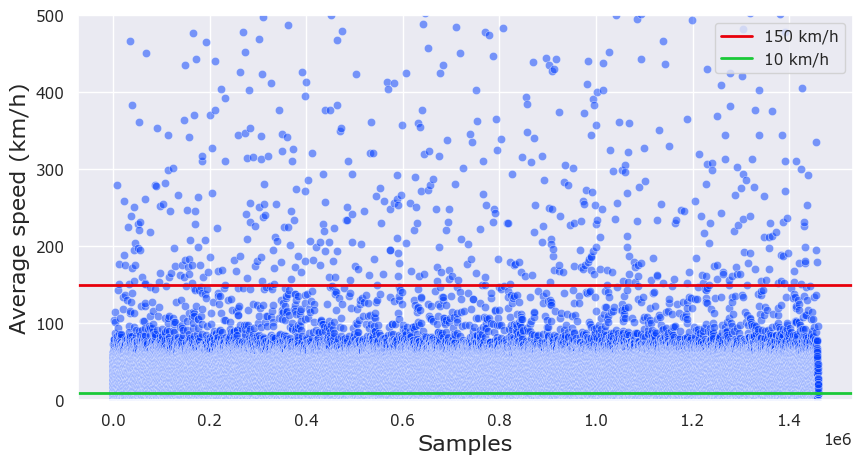

In [106]:
avg_speed = taxi_data['total_distance'] / taxi_data['trip_duration'] * 3.6
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(x=avg_speed.index, y=avg_speed, alpha=0.5, ax=ax)
ax.axhline(y=150, color='r', label='150 km/h')
ax.axhline(y=10, color='g', label='10 km/h')
ax.set_xlabel('Samples')
ax.set_ylabel('Average speed (km/h)')
ax.set_ylim(top=500, bottom=0)
ax.legend()
print(f'Avg speed <10 or >150 count: {(avg_speed>150).sum() + (avg_speed<10).sum()}');

>Будем считать поездки, средняя скорость которых превышает 150 км/ч или ниже 10 км/ч - выбросами

In [135]:
outliers = set(taxi_data[taxi_data['trip_duration'] > 86400].index)
outliers = outliers.union((taxi_data[avg_speed > 150]).index)
outliers = outliers.union((taxi_data[avg_speed < 10]).index)
taxi_data = taxi_data.drop(list(outliers), axis=0).reset_index().drop('index', axis=1)
print(f"Количество удаленных сэмплов: {len(outliers)}")


Количество удаленных сэмплов: 201145


## 2. EDA

Сразу введем логарифмированный целевой признак для дальнейшего удобства оценки по целевой метрике RMSLE: $\epsilon = \sqrt{\frac{1}{n} \sum_{i=1}^n (\log(p_i + 1) - \log(a_i+1))^2 }$

In [136]:
taxi_data['trip_duration_log'] = np.log(taxi_data['trip_duration']+1)

Прежде всего посмотрим на распределение логарифмированной целевой переменной.

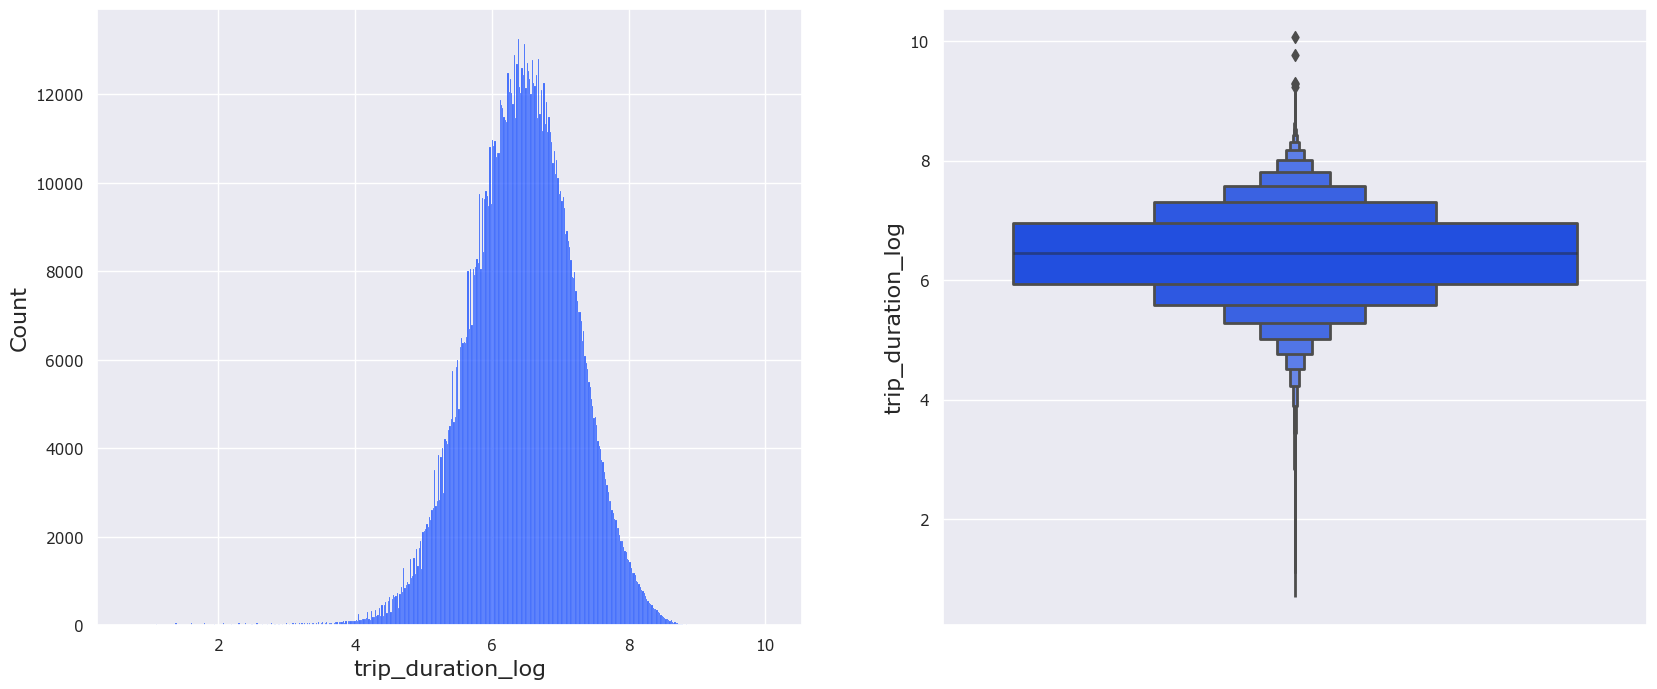

In [113]:
fig, axes = plt.subplots(1,2, figsize=(20,8))
sns.histplot(x=taxi_data['trip_duration_log'], ax=axes[0])
sns.boxenplot(y=taxi_data['trip_duration_log'], ax=axes[1]);

In [40]:
# Проверим насколько вероятно, что распределение целевой переменной является нормальным
from scipy.stats import normaltest
_, pval = normaltest(taxi_data['trip_duration_log'])
print(round(pval*100,3))


0.0


> Статистический тест Д'агостино опроверг гипотезу о том, что сэмплы целевой переменной взяты из нормально-распределенной генеральной совокупности.

Target depends on vendors compression


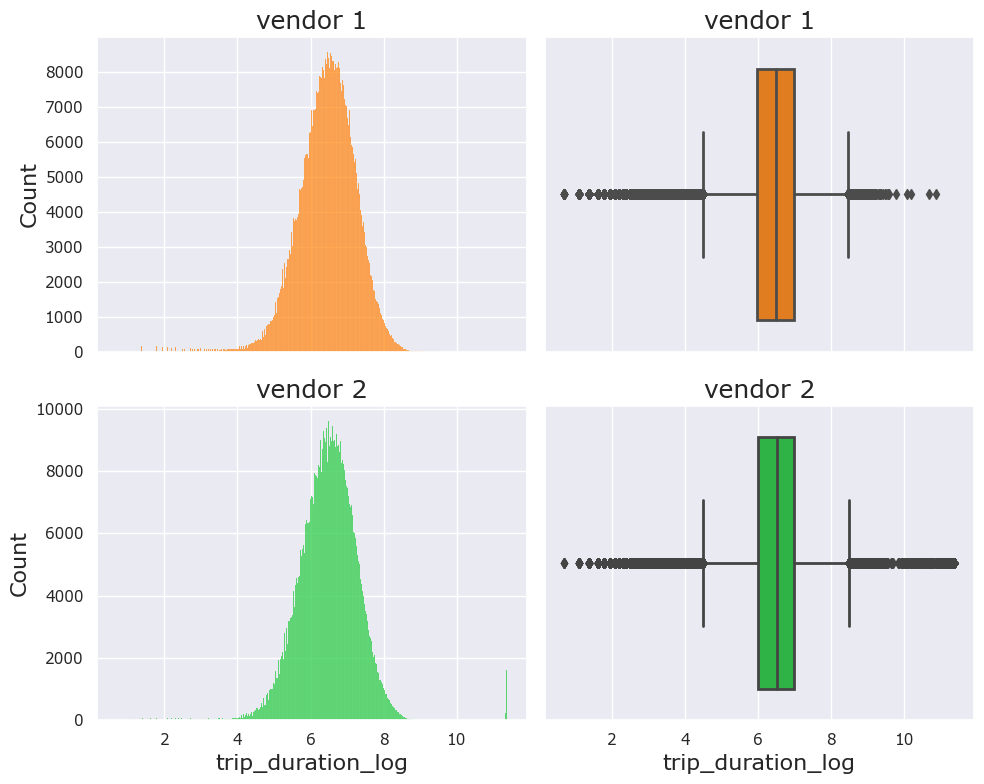

In [41]:
fig, axes = plt.subplots(2,2, sharex='col')
for i in range(1,3):
    sns.histplot(x=taxi_data[taxi_data['vendor_id']==i]['trip_duration_log'], ax=axes[i-1][0], color='C' + str(i)).set(
        title="vendor " + str(i)
    )
    sns.boxplot(x=taxi_data[taxi_data['vendor_id']==i]['trip_duration_log'], ax=axes[i-1][1], color='C' + str(i)).set(
        title="vendor " + str(i)
    )
axes[0][0].set(xlabel='')
axes[0][1].set(xlabel='')
fig.tight_layout()
print("Target depends on vendors compression")


> В целом, распределение целевого признака практически идентично для обоих таксопарков

Target depends on store_and_fwd_flag compresion


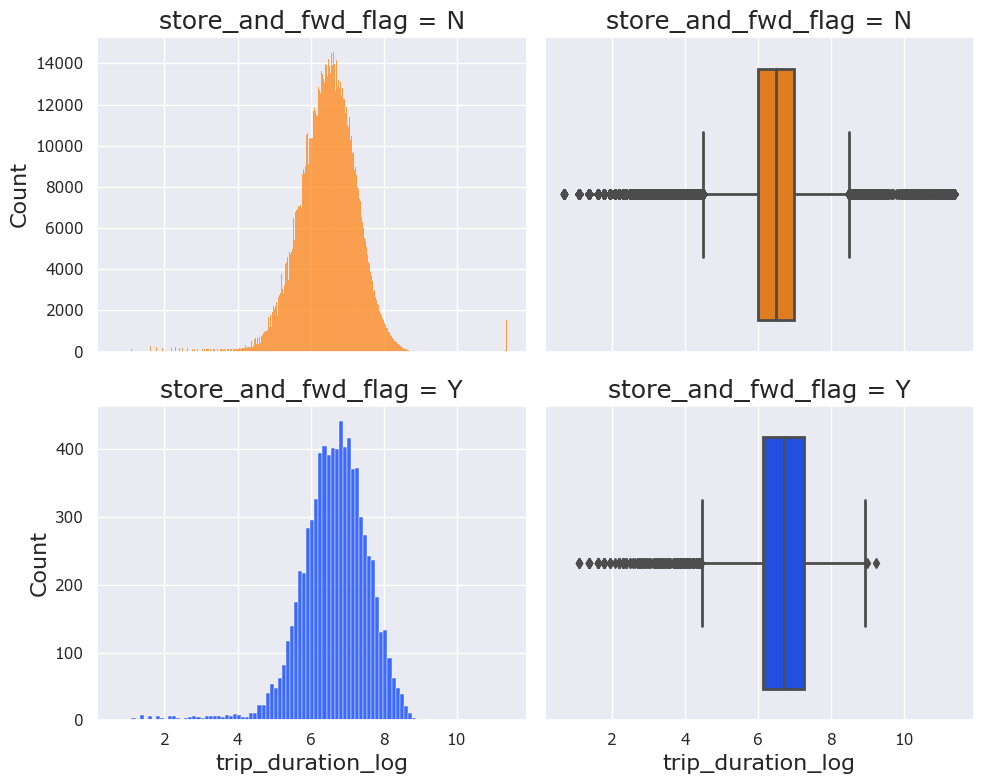

In [20]:
fig, axes = plt.subplots(2,2, sharex='col')
for i, stored in enumerate(['Y', 'N']):
    sns.histplot(x=taxi_data[taxi_data['store_and_fwd_flag']==stored]['trip_duration_log'], ax=axes[i-1][0], color='C' + str(i)).set(
        title="store_and_fwd_flag = " + stored
    )
    sns.boxplot(x=taxi_data[taxi_data['store_and_fwd_flag']==stored]['trip_duration_log'], ax=axes[i-1][1], color='C' + str(i)).set(
        title="store_and_fwd_flag = " + stored
    )
axes[0][0].set(xlabel='')
axes[0][1].set(xlabel='')
fig.tight_layout()
print("Target depends on store_and_fwd_flag compresion")

> Можно видеть, что распределения очень схожи для большинства сэмплов (от 25 до 75 процентиля), однако для сэмплов, хравнившихся в памяти автомобиля перед отправкой на сервер (из-за отсутсвия соединения с последним) высоких значений длительности поездки гораздно меньше.

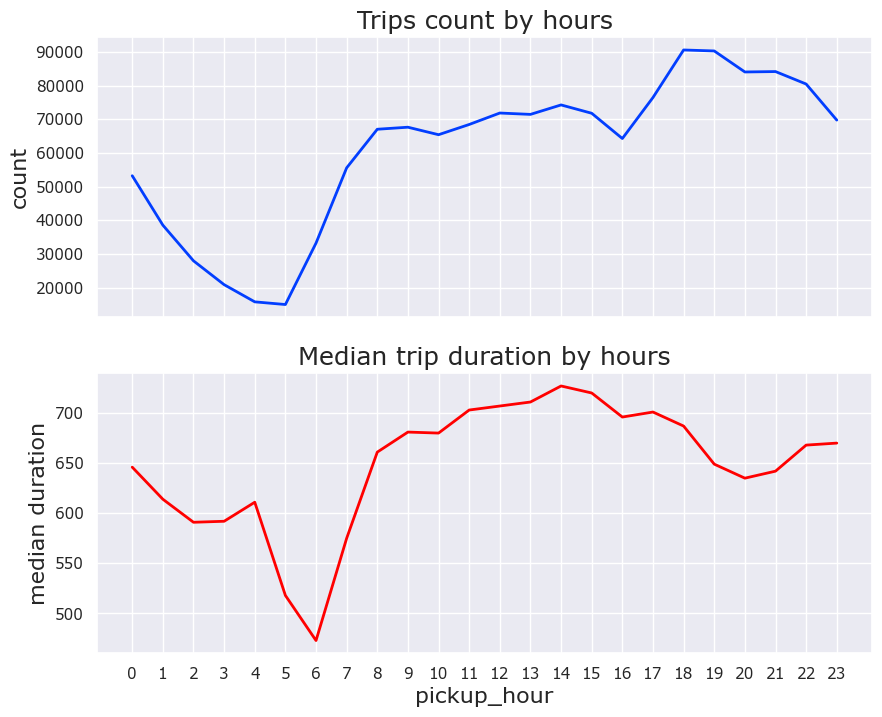

In [21]:
hour_trip_count = taxi_data.groupby('pickup_hour')['id'].count()
hour_trip_duration = taxi_data.groupby('pickup_hour')['trip_duration'].median()
fig, axes = plt.subplots(2,1, sharex=True)
sns.lineplot(data=hour_trip_count, ax=axes[0]).set(
    title='Trips count by hours',
    ylabel='count',
)
sns.lineplot(data=hour_trip_duration, ax=axes[1], color='red').set(
    title='Median trip duration by hours',
    xticks= hour_trip_duration.index,
    ylabel='median duration',
);

> Как видно из графиков, пик количества поездок приходится на 17:00-21:00, однако наиболее длительные в среднем поездки наблюдаются с 11:00 по 18:00

Реализуем такие же графики относительно дней недели.

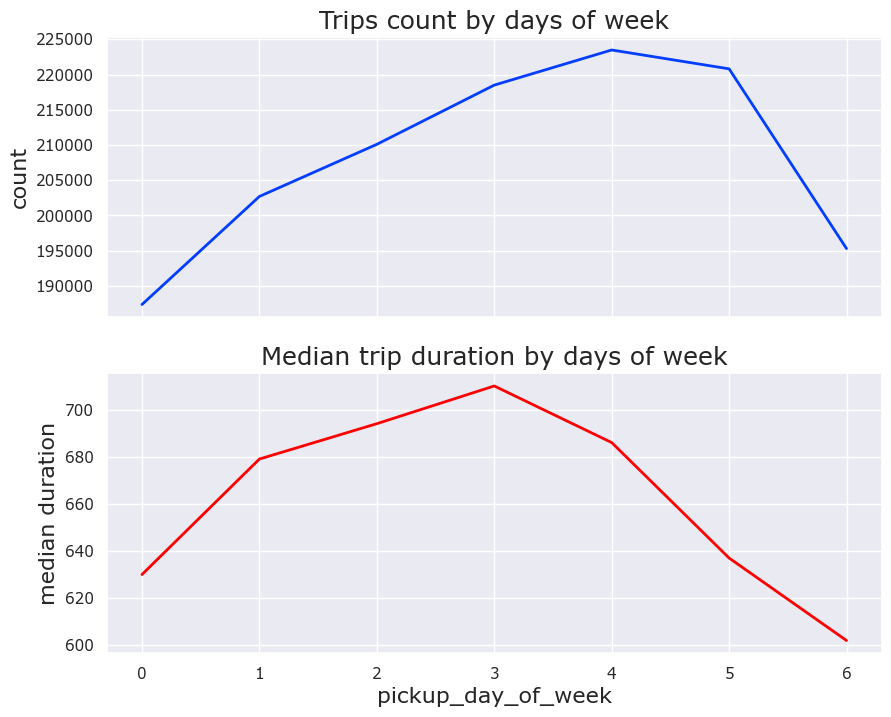

In [22]:
week_trip_count = taxi_data.groupby('pickup_day_of_week')['id'].count()
week_trip_duration = taxi_data.groupby('pickup_day_of_week')['trip_duration'].median()
fig, axes = plt.subplots(2,1, sharex=True)
sns.lineplot(data=week_trip_count, ax=axes[0]).set(
    title='Trips count by days of week',
    ylabel='count',
)
sns.lineplot(data=week_trip_duration, ax=axes[1], color='red').set(
    title='Median trip duration by days of week',
    xticks= week_trip_duration.index,
    ylabel='median duration',
);

> Пик количества поездок приходится на пятницу, вероятнее всего люди выезжают куда либо на выходные. Наиболее длительные же поездки, судя по графику, совершаются по четвергам

Посмотрим на обе временные характеристики одновременно. 

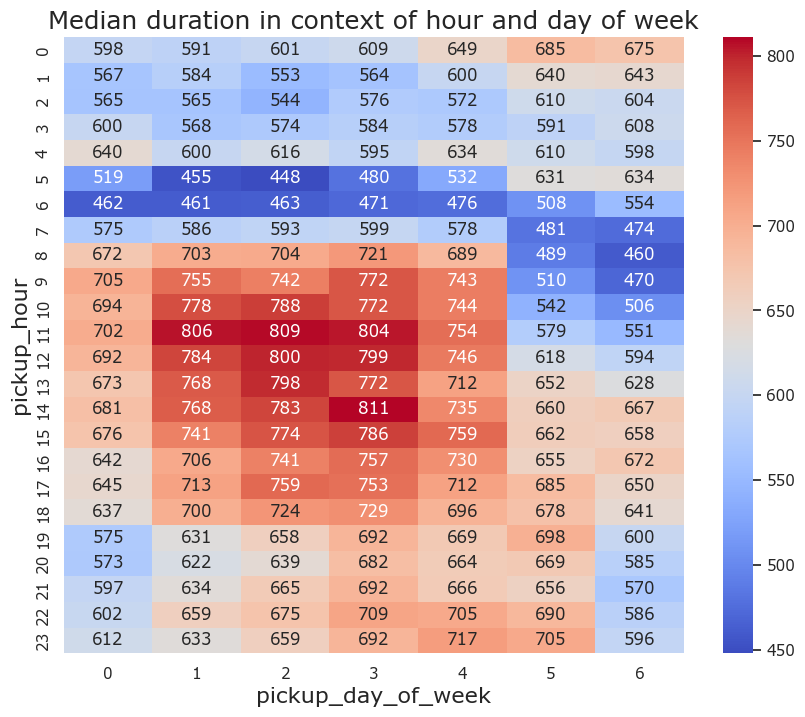

In [23]:
hour_week_piv = pd.pivot_table(data=taxi_data, index='pickup_hour', columns='pickup_day_of_week', values='trip_duration',
                               aggfunc='median')
sns.heatmap(hour_week_piv, annot=True, fmt=".3g", cmap='coolwarm').set(
    title="Median duration in context of hour and day of week",
);

> Самые продолжительные в медианном смысле поездки наблюдались с понедельника по пятницу с 8 до 18 часов, максимальное же значение длительноси наблюдается в четверг в около 14:00


Теперь посмотрим на распределение координат точек посадки-высадки и то, как на них отработала кластеризация KMeans. При этом будем учитывать только поездки, начавшиеся и окончившиеся в черте Нью-Йорка, определив соответствующие границы для широты и долготы.


[Text(0.5, 1.0, 'Dropoff coords'), Text(0.5, 0, 'longitude')]

C:\Users\mblyz\AppData\Roaming\Python\Python311\site-packages\IPython\core\events.py:93: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\mblyz\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


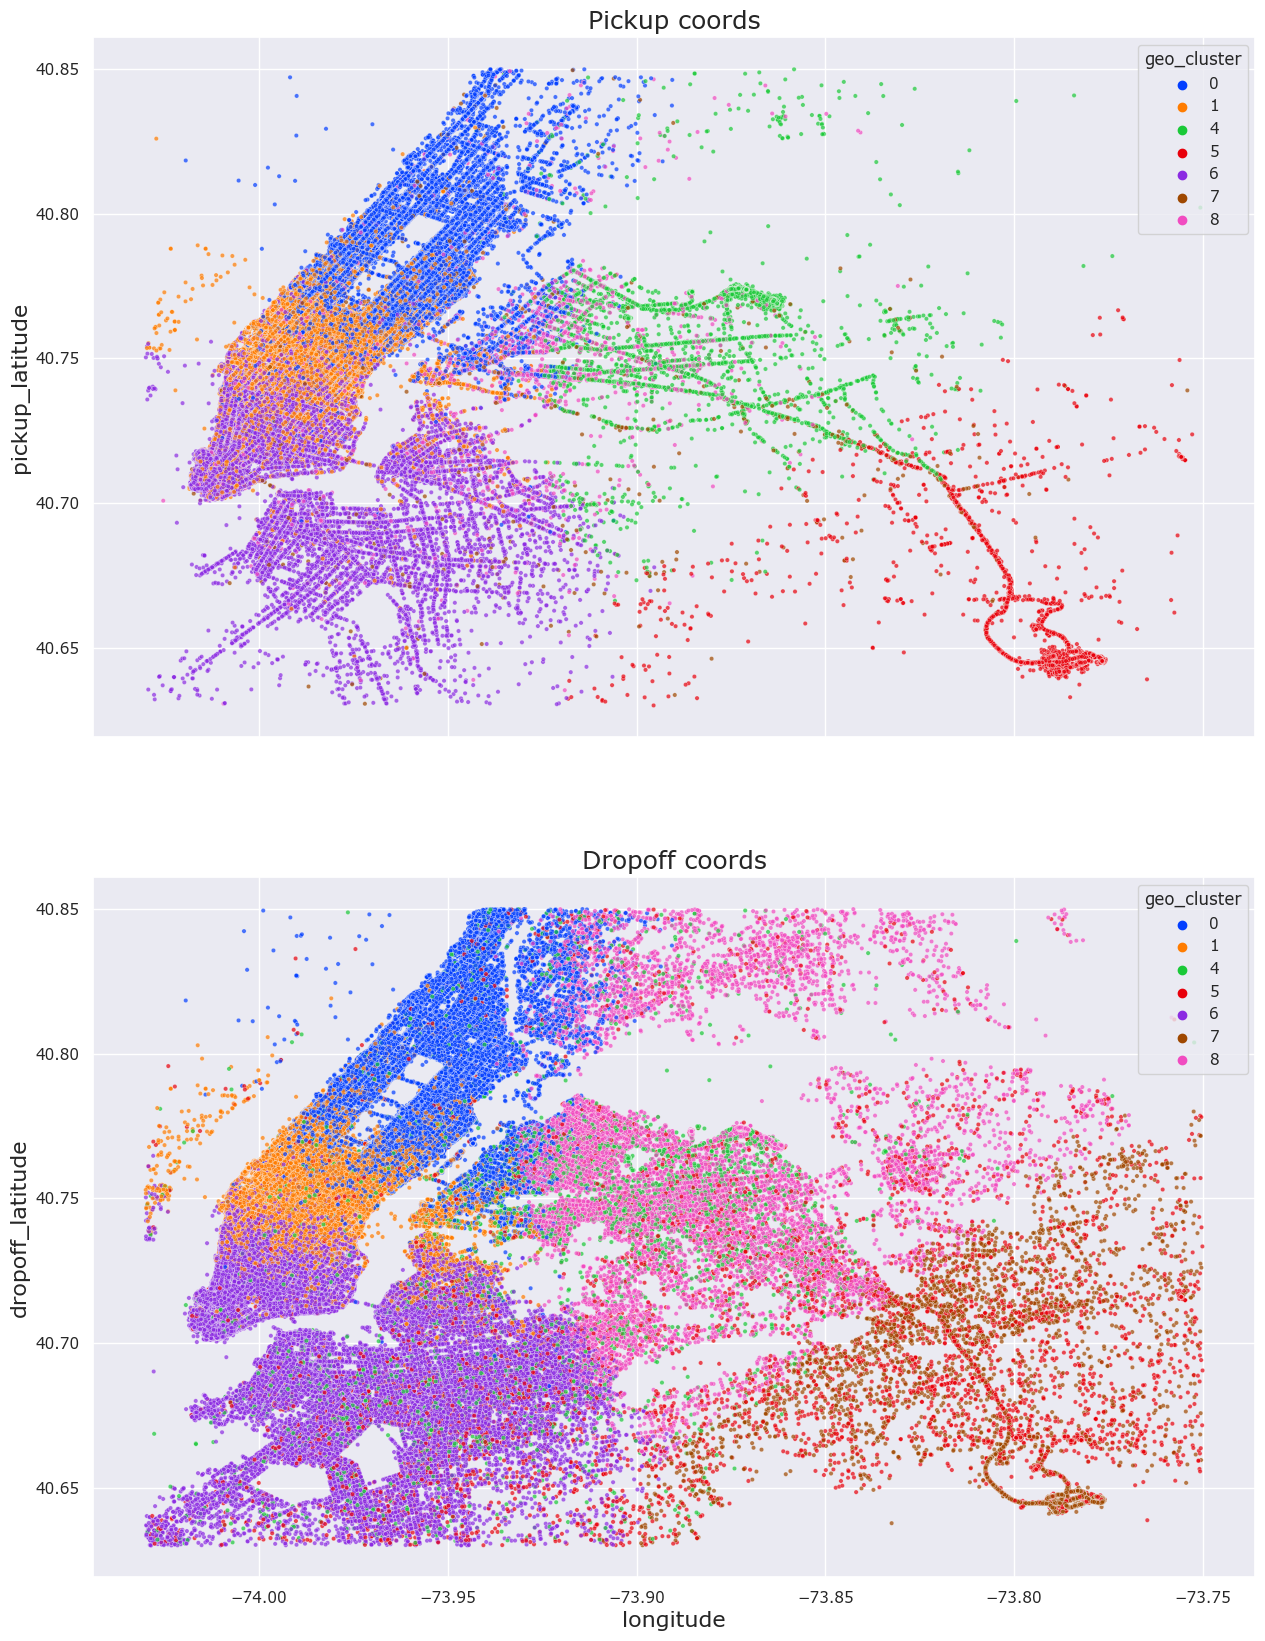

In [25]:
# определим границы Нью-Йорка
city_long_border = (-74.03, -73.75) 
mask_lon = (city_long_border[0] <= taxi_data['pickup_longitude']) &  (taxi_data['pickup_longitude'] <= city_long_border[1]) & \
           (city_long_border[0] <= taxi_data['dropoff_longitude']) &  (taxi_data['dropoff_longitude'] <= city_long_border[1])
city_lat_border = (40.63, 40.85)
mask_lat = (city_lat_border[0] <= taxi_data['pickup_latitude']) &  (taxi_data['pickup_latitude'] <= city_lat_border[1]) & \
           (city_lat_border[0] <= taxi_data['dropoff_latitude']) &  (taxi_data['dropoff_latitude'] <= city_lat_border[1])
# Выделим данные, соответсвующие этим границам
new_york_coords = taxi_data[mask_lon & mask_lat]
fig, axes = plt.subplots(2,1, sharex='col', figsize=(15,20))
sns.scatterplot(new_york_coords, x='pickup_longitude', y='pickup_latitude', s=10, alpha=0.7, hue='geo_cluster', 
                ax=axes[0], legend='brief', palette='bright').set(title='Pickup coords')
sns.scatterplot(new_york_coords, x='dropoff_longitude', y='dropoff_latitude',s=10, alpha=0.7,hue='geo_cluster', 
                ax=axes[1], legend='brief', palette='bright').set(title='Dropoff coords', xlabel='longitude');


> В соответствие с результатами алгоритма KMeans, где 2,3 и 9 кластеры содержат в себе буквально несколько сэмплов и учитывая, что эти кластери не присутствуют на визулизации выше для поездок в черте Нью-Йорка, эти кластеры представляют собой шум.

## 3. Отбор и преобразование признаков

Перед тем как перейти к построению модели, осталось сделать ещё несколько шагов.
* Следует помнить, что многие алгоритмы машинного обучения не могут обрабатывать категориальные признаки в их обычном виде. Поэтому нам необходимо их закодировать;
* Надо отобрать признаки, которые мы будем использовать для обучения модели;
*  Необходимо масштабировать и трансформировать некоторые признаки для того, чтобы улучшить сходимость моделей, в основе которых лежат численные методы.


In [42]:
print('Shape of data: {}'.format(taxi_data.shape))
print('Columns: {}'.format(taxi_data.columns))

Shape of data: (1458062, 27)
Columns: Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_date', 'pickup_hour', 'pickup_day_of_week',
       'pickup_holiday', 'total_distance', 'total_travel_time',
       'number_of_steps', 'haversine_distance', 'bearing_angle', 'geo_cluster',
       'temperature', 'visibility', 'wind speed', 'precip', 'events',
       'trip_duration_log'],
      dtype='object')


In [138]:
train_data = taxi_data.copy()
train_data.head()


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,number_of_steps,haversine_distance,bearing_angle,geo_cluster,temperature,visibility,wind speed,precip,events,trip_duration_log
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,5.0,1.498521,99.970196,0,4.4,8.0,27.8,0.3,None,6.122493
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,6.0,1.805507,-117.153768,6,28.9,16.1,7.4,0.0,None,6.498282
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,16.0,6.385098,-159.680165,6,-6.7,16.1,24.1,0.0,None,7.661527
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,4.0,1.485498,-172.737700,6,7.2,16.1,25.9,0.0,None,6.063785
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,5.0,1.188588,179.473585,0,9.4,16.1,9.3,0.0,None,6.077642


Избавимся от неинформативных признаков: `id`; `pickup_datetime` и `pickup_date`, с помощью которых мы уже извлекли всю полезную информацию, а также от очевидной утечки данных `dropoff_datetime`.

In [139]:
drop_columns = ['id', 'dropoff_datetime', 'pickup_datetime', 'pickup_date']
train_data.drop(drop_columns, axis=1, inplace=True)
print('Shape of data:  {}'.format(train_data.shape))

Shape of data:  (1257499, 23)


Закодируем равнозначным образом бинарные бинарные признаки

In [140]:
train_data['store_and_fwd_flag'] = train_data['store_and_fwd_flag'].apply(lambda x: 1 if x=='Y' else 0)
train_data['vendor_id'] = train_data['vendor_id'].apply(lambda x: 1 if x==2 else 0)


Закодируем однократным кодированием оставшиеся номинальные признаки

In [141]:
oh_encoder = preprocessing.OneHotEncoder(drop='first', sparse_output=False)
oh_cols = ['pickup_day_of_week', 'geo_cluster', 'events']
data_onehot = oh_encoder.fit_transform(train_data[oh_cols])
data_onehot = pd.DataFrame(data_onehot, columns=oh_encoder.get_feature_names_out())
train_data = pd.concat([train_data.drop(oh_cols, axis=1), data_onehot], axis=1)
print(f'Shape of data: {(train_data.shape)}')

Shape of data: (1257499, 35)


In [142]:
X = train_data.drop(['trip_duration', 'trip_duration_log'], axis=1)
y = train_data['trip_duration']
y_log = train_data['trip_duration_log']

Все модели будут обучаться на логарифмированной версии целевой переменной - `y_log`

Разобьем данные на обучающую и валидационную подвыборки

In [143]:
X_train, X_valid, y_train_log, y_valid_log = model_selection.train_test_split(
    X, y_log, 
    test_size=0.33, 
    random_state=R_STATE
)

C помощью селектора `SelectKBest` со score-функцией f_regression, основанной на корреляции Пирсона предикторов с целевой переменной отберем для обучения моделей 25 признаков, а также визуализируем 10 признаков с наибольшим значением score-функции


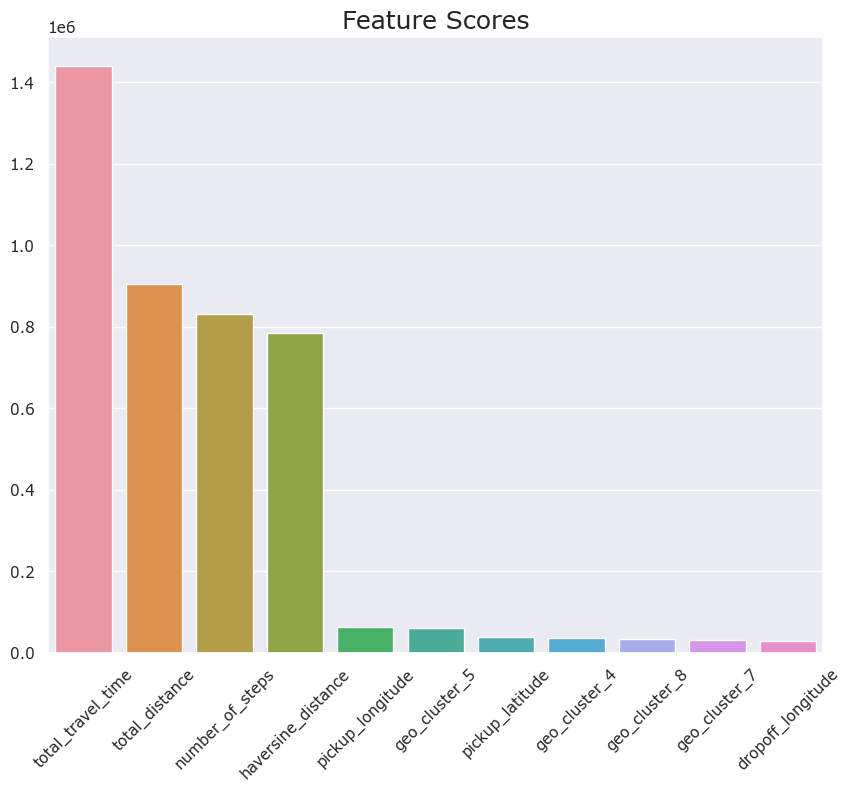

In [144]:
selector = feature_selection.SelectKBest(score_func=feature_selection.f_regression, k=25)
X_train = selector.fit_transform(X_train, y_train_log)
X_valid = selector.transform(X_valid)
features_sorted_by_score = [name for name, score in sorted(zip(selector.feature_names_in_, selector.scores_), key= lambda item: -item[1])]
ax = sns.barplot(x=features_sorted_by_score[:11], y=sorted(selector.scores_)[:-12:-1])
ax.set_title("Feature Scores")
ax.xaxis.set_tick_params(rotation=45);

В завершение подготовки данных нормализуем их при помощи MinMaxScaler


In [145]:
mm_scaler = preprocessing.MinMaxScaler()
X_train = mm_scaler.fit_transform(X_train)
X_valid = mm_scaler.transform(X_valid)


## 4. Линейная, полиномиальная регрессия и деревья решений

Метрику, по которой будем оценивать результаты предсказаний сохраним с исходного соревнования Kaggle (Root Mean Squared Log Error): 
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(log(y_i+1)-log(\hat{y_i}+1))^2},$$
где:
* $y_i$ - истинная длительность i-ой поездки на такси (trip_duration)
* $\hat{y_i}$- предсказанная моделью длительность i-ой поездки на такси

Учитывая, что выше мы уже создавали признак целевой переменной в лог. масштабе,
$$RMSLE = \sqrt{MSE(z_i,\hat{z_i})}$$ 
$$z_i=log(y_i+1),$$





В качестве базовой модели возьмем линейную регрессию, которая будет предсказывать целевой признак в логарифмическом масштабе.


In [146]:
def rmsle(y_true_log, y_pred_log):
    return (metrics.mean_squared_error(y_true_log, y_pred_log))**0.5

In [147]:
base_lr = linear_model.LinearRegression()
base_lr.fit(X_train, y_train_log)
print(f"LR train score: {rmsle(y_train_log, base_lr.predict(X_train)):.3f}")
print(f"LR valid score: {rmsle(y_valid_log, base_lr.predict(X_valid)):.3f}")

LR train score: 0.424
LR valid score: 0.422


Также обучим полиномиальную регрессию 2-й степени

In [54]:
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_valid_poly = poly.transform(X_valid)
poly_lr = linear_model.LinearRegression()
poly_lr.fit(X_train_poly, y_train_log)
print(f"LR on 2 deg. polynom train score: {rmsle(y_train_log, poly_lr.predict(X_train_poly)):.3f}")
print(f"LR on 2 deg. polynom  valid score: {rmsle(y_valid_log, poly_lr.predict(X_valid_poly)):.3f}")

LR on 2 deg. polynom train score: 0.467
LR on 2 deg. polynom  valid score: 0.601


Полиномиальная регрессия на полиноме второй степени уже склонна к переобучению

Попробуем построить гребневую регрессию на полиномиальных признаках второй степени (регрессия с L2 регуляризацией), чтобы решить проблему переобучения, коэффицент регуляризации подбирать не будем, т.к в данном случае важнее уследить общую тенденцию и понять базовый результат по метрике.


In [55]:
ridge_poly = linear_model.Ridge(alpha=1, random_state=R_STATE)
ridge_poly.fit(X_train_poly, y_train_log)
print(f"Ridge on 2 deg. polynom train score: {rmsle(y_train_log, ridge_poly.predict(X_train_poly)):.3f}")
print(f"Ridge on 2 deg. polynom  valid score: {rmsle(y_valid_log, ridge_poly.predict(X_valid_poly)):.3f}")

Ridge on 2 deg. polynom train score: 0.476
Ridge on 2 deg. polynom  valid score: 0.476


Используя полиномиальные признаки второй степени и регуляризацию удалось избежать переобучения обычной полиномиальной регресси и улучшить значение метрики на валидационной выборке ~ на 0.6 относительно линейной регрессии.

Также в качестве базовой модели посмотрим на результат регрессионного дерева решений с итерационным перебором параметра максимальной глубины в заданных диапозонах. На валидационной кривой покажем зависимость целевой метрики на валидации относительно выбранного гиперпараметра.

[Text(0.5, 0, 'max_depth parametr'), Text(0, 0.5, 'RMSLE')]

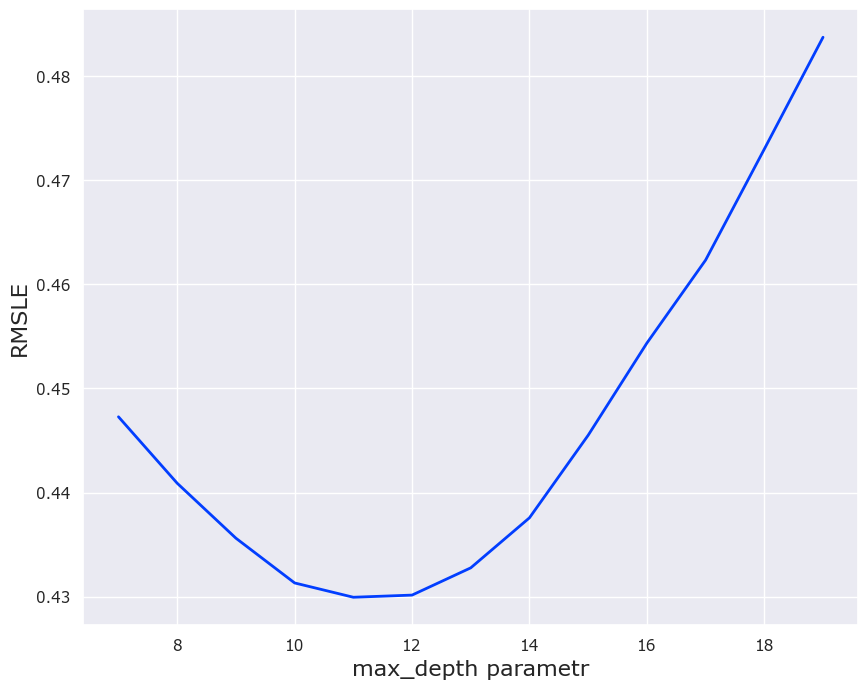

In [40]:
max_depths = range(7,20)
validation_score = []
for max_depth in max_depths:
    dt_model = tree.DecisionTreeRegressor(max_depth=max_depth, random_state=R_STATE)
    dt_model.fit(X_train, y_train_log)
    validation_score.append(rmsle(y_valid_log, dt_model.predict(X_valid)))
sns.lineplot(x=max_depths, y=validation_score).set(
    xlabel='max_depth parametr',
    ylabel='RMSLE'
)
# print(f"Dtree train score: {rmsle(y_train_log, dt_model.predict(X_train)):.3f}")
# print(f"Dtree on 2 deg. polynom  valid score: {rmsle(y_valid_log, dt_model.predict(X_valid)):.3f}")

Судя по кривой валидации дерево решений глубиной 11 оптимально для наших данных и достигает RMSLE=0.43

## 5. Ансамблевые методы 

Для начала посмотрим как отработает случайный лес с подобранными "на глаз" основными параметрами.

In [74]:
rf_model = ensemble.RandomForestRegressor(n_estimators=200, max_depth=12, min_samples_split=20, n_jobs=-1,  verbose=1, random_state=R_STATE)
rf_model.fit(X_train, y_train_log)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  9.4min finished


RandomForestRegressor(max_depth=12, min_samples_split=20, n_estimators=200,
                      n_jobs=-1, random_state=42, verbose=1)

In [77]:
print(f"Random forest train score: {rmsle(y_train_log, rf_model.predict(X_train)):.3f}")
print(f"Random forest valid score: {rmsle(y_valid_log, rf_model.predict(X_valid)):.3f}")

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.5s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    3.3s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    3.7s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.


Random forest train score: 0.399


[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    1.7s


Random forest valid score: 0.414


[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    1.9s finished


In [56]:
gb_model = ensemble.GradientBoostingRegressor(
    learning_rate=0.5,
    n_estimators=100,
    max_depth=6,
    min_samples_split=30,
    random_state=R_STATE,
    verbose=1,
)
gb_model.fit(X_train, y_train_log)

      Iter       Train Loss   Remaining Time 
         1           0.3105           17.55m
         2           0.2251           16.15m
         3           0.1984           14.99m
         4           0.1876           14.21m
         5           0.1825           13.51m
         6           0.1785           13.03m
         7           0.1756           12.70m
         8           0.1731           12.39m
         9           0.1715           12.10m
        10           0.1695           11.90m
        20           0.1601            9.94m
        30           0.1532            8.52m
        40           0.1503            7.13m
        50           0.1476            5.92m
        60           0.1452            4.70m
        70           0.1433            3.52m
        80           0.1416            2.33m
        90           0.1399            1.15m
       100           0.1385            0.00s


GradientBoostingRegressor(learning_rate=0.5, max_depth=6, min_samples_split=30,
                          random_state=42, verbose=1)

In [162]:
print(f"sklearn GB train score: {rmsle(y_train_log, gb_model.predict(X_train)):.3f}") #0.372
print(f"sklearn GB valid score: {rmsle(y_valid_log, gb_model.predict(X_valid)):.3f}") #0.392

sklearn GB train score: 1.919
sklearn GB valid score: 1.915


Градиентный бустинг показал лучший результат в сравнении со случайным лесом и тем более с базовыми моделями, полезно будет посмотреть на важность исходных факторов в полученной модели

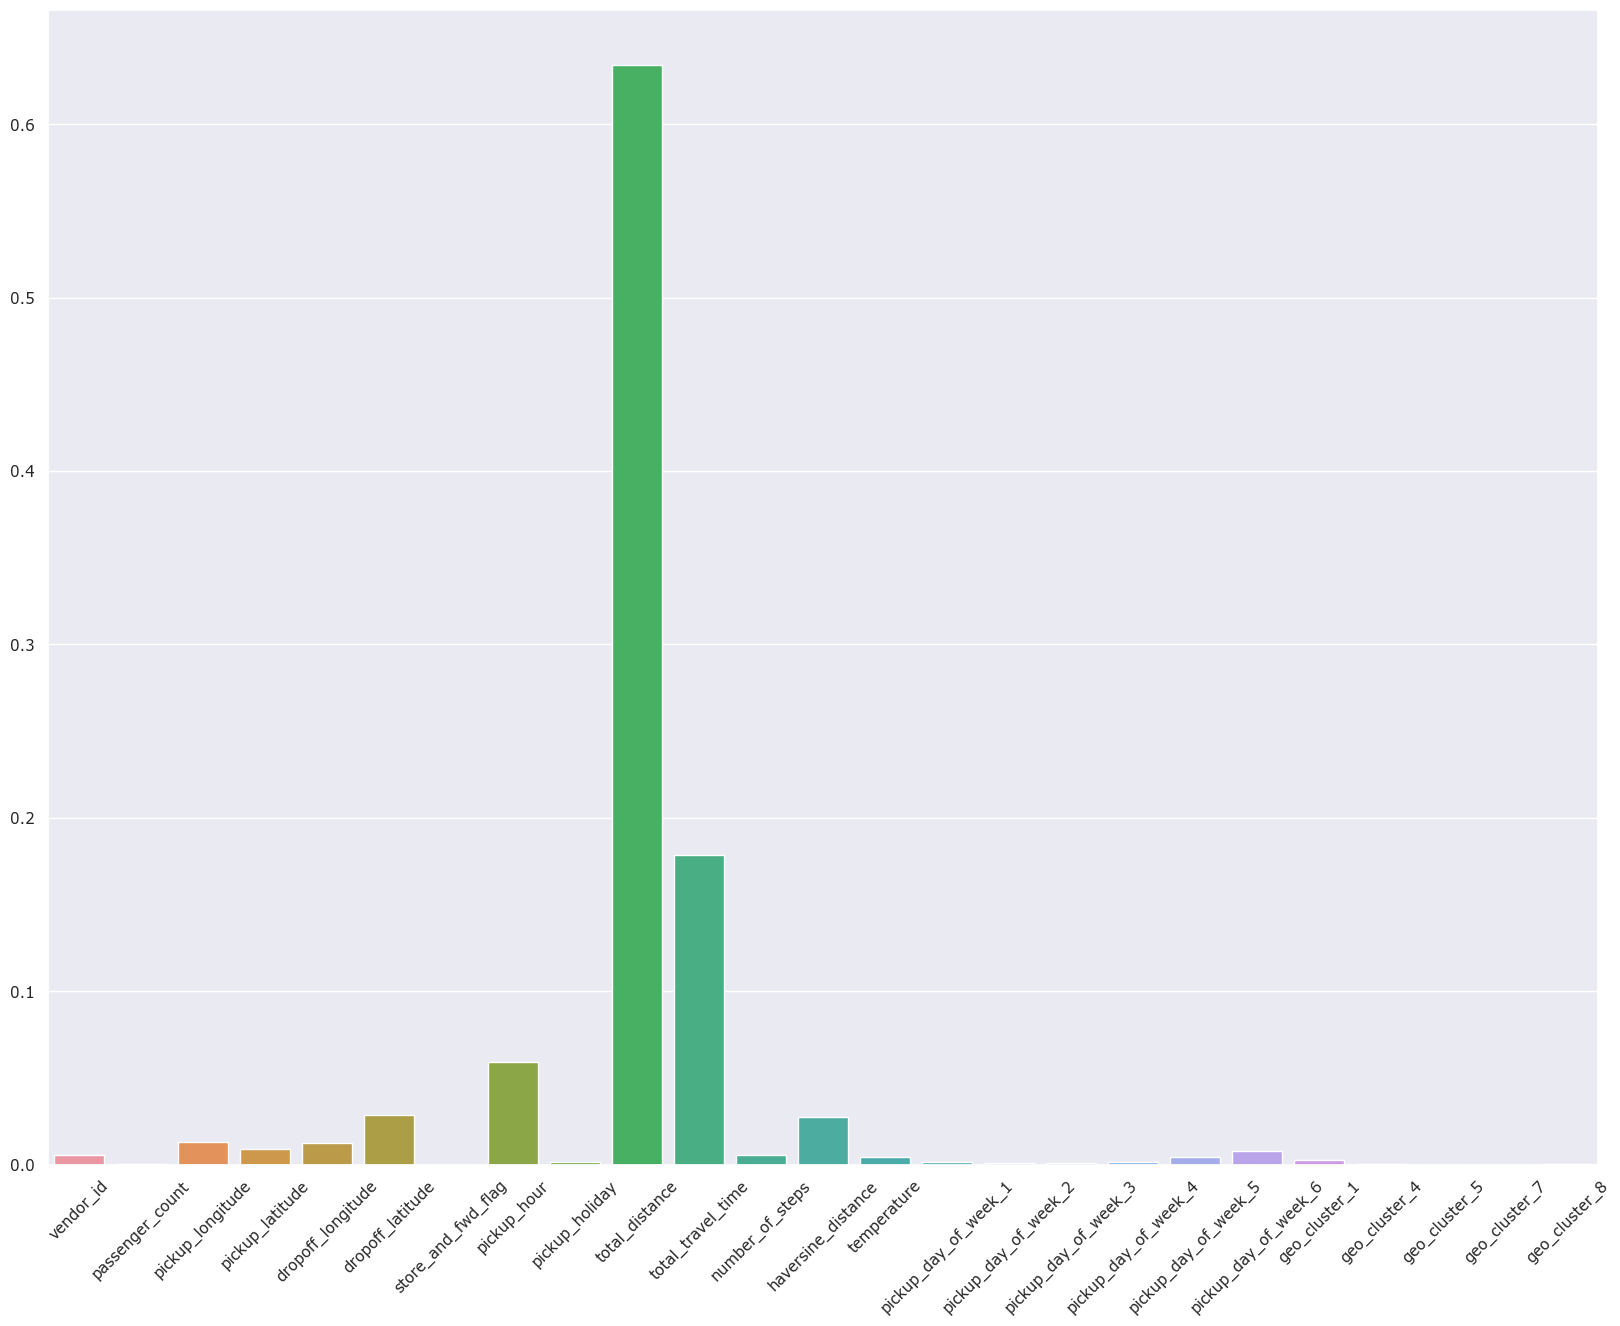

In [58]:
fig, ax = plt.subplots(figsize=(20,15))
sns.barplot(x=selector.get_feature_names_out(), y=gb_model.feature_importances_, ax=ax)
ax.xaxis.set_tick_params(rotation=45)

Наиболее важными для модели градиентного бустинга над деревьями решений оказались признаки полного дорожного расстрояния и времени, требуемого на дорогу, полученные с помощью OSRM. Также влияние оказывает признак, отражающий час заказа поездки и расстояние Хаверсина.

В качестве интерпретируемой метрики логично будет посмотреть на медианную абсолютную ошибку

In [161]:
print(f"Median error in minutes {metrics.median_absolute_error(np.exp(y_valid_log)-1, np.exp(gb_model.predict(X_valid))-1)/60:.2f}")

Median error in minutes 35.08


Далее сделаем предсказание для тестовых данных с помощью модели, показавшей наилучшую матрику на валидации


In [156]:
test_data = pd.read_csv("data/test.csv")
osrm_data_test = pd.read_csv("data/osrm_data_test.csv") # osrm признаки для тестового набора 
test_id = test_data['id']


Применим к тестовому набору те же функции для генерации признаки и манипуляции с данными, что и для тренировочного набора.


In [157]:
test_data['pickup_datetime']=pd.to_datetime(test_data['pickup_datetime'],format='%Y-%m-%d %H:%M:%S')
test_data = add_datetime_features(test_data)
test_data = add_holiday_feature(test_data, holiday_data)
test_data = add_osrm_features(test_data, osrm_data_test, osrm_cols)
test_data = add_geographical_features(test_data)
test_data = add_cluster_feature(test_data, kmeans)
test_data = add_weather_features(test_data, weather_data, weather_cols)
test_data = fill_null_values(test_data)

test_data['vendor_id'] = test_data['vendor_id'].apply(lambda x: 1 if x == 2 else 0)
test_data['store_and_fwd_flag'] = test_data['store_and_fwd_flag'].apply(lambda x: 1 if x == 'Y' else 0)

test_data_onehot = oh_encoder.fit_transform(test_data[oh_cols])
column_names = oh_encoder.get_feature_names_out(oh_cols)
test_data_onehot = pd.DataFrame(test_data_onehot, columns=column_names)
test_data = pd.concat(
    [test_data.reset_index(drop=True).drop(oh_cols, axis=1), test_data_onehot], 
    axis=1
)
X_test = test_data[selector.get_feature_names_out()]
X_test_scaled = mm_scaler.transform(X_test)
print('Shape of data: {}'.format(X_test.shape))

Shape of data: (625134, 25)


c:\Users\mblyz\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


Только после выполнения всех этих шагов можно сделать предсказание длительности поездки для тестовой выборки. Не забудьте перевести предсказания из логарифмического масштаба в истинный, используя формулу:
$$y_i=exp(z_i)-1$$

После того, как вы сформируете предсказание длительности поездок на тестовой выборке вам необходимо будет создать submission-файл в формате csv, отправить его на платформу Kaggle и посмотреть на результирующее значение метрики RMSLE на тестовой выборке.

Код для создания submission-файла:


In [158]:
y_test_predict = np.exp(gb_model.predict(X_test_scaled)) - 1
submission = pd.DataFrame({'id': test_id, 'trip_duration': y_test_predict})
submission.to_csv('data/submission_gb.csv', index=False)

### **В качестве бонуса**

В завершение по ансамблевым мы предлагаем вам попробовать улучшить свое предсказание, воспользовавшись моделью экстремального градиентного бустинга (XGBoost) из библиотеки xgboost.

**XGBoost** - современная модель машинного обучения, которая является продолжением идеи градиентного бустинга Фридмана. У нее есть несколько преимуществ по сравнению с классической моделью градиентного бустинга из библиотеки sklearn: повышенная производительность путем параллелизации процесса обучения, повышенное качество решения за счет усовершенствования алгоритма бустинга, меньшая склонность к переобучению и широкий функционал возможности управления параметрами модели.


Для ее использования необходимо для начала установить пакет xgboost:

In [ ]:
#!pip install xgboost

После чего модуль можно импортировать:

In [ ]:
import xgboost as xgb

Перед обучением модели необходимо перевести наборы данных в тип данных xgboost.DMatrix:

In [ ]:
# Создание матриц наблюдений в формате DMatrix
dtrain = xgb.DMatrix(X_train_scaled, label=y_train_log, feature_names=best_features)
dvalid = xgb.DMatrix(X_valid_scaled, label=y_valid_log, feature_names=best_features)
dtest = xgb.DMatrix(X_test_scaled, feature_names=best_features)

Обучение модели XGBoost происходит с помощью метода train, в который необходимо передать параметры модели, набор данных, количество базовых моделей в ансамбле, а также дополнительные параметры:


In [ ]:
# Гиперпараметры модели
xgb_pars = {'min_child_weight': 20, 'eta': 0.1, 'colsample_bytree': 0.9, 
            'max_depth': 6, 'subsample': 0.9, 'lambda': 1, 'nthread': -1, 
            'booster' : 'gbtree', 'eval_metric': 'rmse', 'objective': 'reg:squarederror'
           }
# Тренировочная и валидационная выборка
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
# Обучаем модель XGBoost
model = xgb.train(
    params=xgb_pars, #гиперпараметры модели
    dtrain=dtrain, #обучающая выборка
    num_boost_round=300, #количество моделей в ансамбле
    evals=watchlist, #выборки, на которых считается матрица
    early_stopping_rounds=20, #раняя остановка
    maximize=False, #смена поиска максимума на минимум
    verbose_eval=10 #шаг, через который происходит отображение метрик
)

Предсказать целевой признак на новых данных можно с помощью метода predict():

In [ ]:
#Делаем предсказание на тестовом наборе данных
y_test_predict = np.exp(model.predict(dtest)) - 1
print('Modeling RMSLE %.5f' % model.best_score)

Также как и все модели, основанные на использовании деревьев решений в качестве базовых моделей, XGBoost имеет возможность определения коэффициентов важности факторов. Более того, в библиотеку встроена возможность визуализации важность факторов в виде столбчатой диаграммы. За эту возможность отвечает функция plot_importance():


In [ ]:
fig, ax = plt.subplots(figsize = (15,15))
xgb.plot_importance(model, ax = ax, height=0.5)